In [2]:
import psycopg2

def auto_indexing(database, user, password, host, port):
    # Establish a connection to the PostgreSQL database
    conn = psycopg2.connect(database=database, user=user, password=password, host=host, port=port)

    # Create a cursor object
    cur = conn.cursor()

    # Analyze query performance
    cur.execute("SELECT query, total_time, calls FROM pg_stat_statements ORDER BY total_time DESC LIMIT 10;")
    query_stats = cur.fetchall()

    for query_stat in query_stats:
        query = query_stat[0]
        total_time = float(query_stat[1])
        calls = int(query_stat[2])

        # Extract the table and column names from the query
        table_name = query.split("FROM ")[1].split(" ")[0]
        columns = query.split("WHERE ")[1].split(" = ")[0].split(" AND ")

        for column in columns:
            # Check if an index already exists on the column
            cur.execute(f"SELECT indexname FROM pg_indexes WHERE tablename = '{table_name}' AND indexdef ILIKE '%{column}%';")
            existing_index = cur.fetchone()

            # Create index if it doesn't exist and the query performance is poor
            if existing_index is None and total_time > 0.1:  # Adjust the threshold based on your performance requirements
                index_name = f"{table_name}_{column}_idx"
                cur.execute(f"CREATE INDEX {index_name} ON {table_name} ({column});")
                conn.commit()
                print(f"Index '{index_name}' created on '{column}' column in '{table_name}' table.")
            else:
                print(f"An index already exists on '{column}' column in '{table_name}' table.")

    cur.close()
    conn.close()

# Example usage:
auto_indexing("postgres", "postgres", "qwerty", "localhost", "5433")


UndefinedColumn: column "total_time" does not exist
LINE 1: SELECT query, total_time, calls FROM pg_stat_statements ORDE...
                      ^


In [11]:
import psycopg2

def auto_indexing(database, user, password, host, port):
    # Connect to the database
    conn = psycopg2.connect(database=database, user=user, password=password, host=host, port=port)
    cur = conn.cursor()

    # Get the list of table names from the database
    cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    tables = cur.fetchall()

    # Iterate over each table and analyze query performance
    for table in tables:
        table_name = table[0]
        print(f"Table: {table_name}")

        # Analyze query performance
        cur.execute(f"SELECT query, rows FROM pg_stat_statements WHERE query LIKE '%{table_name}%' ORDER BY rows DESC LIMIT 10;")
        query_stats = cur.fetchall()

        # Print query analysis
        print("Query Analysis:")
        print("-" * 80)
        for query_stat in query_stats:
            query = query_stat[0]
            rows = query_stat[1]
            print(f"Query: {query}")
            print(f"Rows: {rows}")
            print("-" * 80)

    # Close the database connection
    cur.close()
    conn.close()

# Example usage:
auto_indexing("postgres", "postgres", "qwerty", "localhost", "5433")


Table: customers
Query Analysis:
--------------------------------------------------------------------------------
Table: orders
Query Analysis:
--------------------------------------------------------------------------------
Table: query_performance_log
Query Analysis:
--------------------------------------------------------------------------------
Table: query_log
Query Analysis:
--------------------------------------------------------------------------------
Table: pg_stat_statements
Query Analysis:
--------------------------------------------------------------------------------
Query: SELECT query, rows FROM pg_stat_statements WHERE query LIKE $1 ORDER BY rows DESC LIMIT $2
Rows: 3
--------------------------------------------------------------------------------
Query: SELECT pg_stat_statements_reset()
Rows: 1
--------------------------------------------------------------------------------
Query: CREATE EXTENSION IF NOT EXISTS pg_stat_statements
Rows: 0
------------------------------

In [14]:
import psycopg2

def auto_indexing(database, user, password, host, port):
    # Connect to the database
    conn = psycopg2.connect(database=database, user=user, password=password, host=host, port=port)
    cur = conn.cursor()

    # Get the list of table names from the database
    cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    tables = cur.fetchall()

    # Iterate over each table and find the best-suited non-primary key for indexing
    for table in tables:
        table_name = table[0]
        print(f"Table: {table_name}")

        # Get the list of column names for the table
        cur.execute(f"SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}';")
        columns = cur.fetchall()

        best_index = None
        best_index_size = float('inf')

        # Iterate over each column and calculate the index size
        for column in columns:
            column_name = column[0]
            if column_name == 'id':  # Skip the primary key column
                continue

            try:
                # Calculate the index size for the column
                cur.execute(f"SELECT pg_total_relation_size('public.{table_name}') - pg_relation_size('public.{table_name}') "
                            f"FROM public.{table_name} WHERE {column_name} IS NOT NULL;")
                index_size = int(cur.fetchone()[0])  # Convert index size to numeric value

                # Update the best index if the current index size is smaller
                if index_size < best_index_size:
                    best_index = column_name
                    best_index_size = index_size
            except TypeError:
                # Handle the case where index size calculation fails
                print(f"No suitable non-primary key for indexing found in table: {table_name}")
                break

        if best_index is not None:
            # Print the best-suited non-primary key for indexing
            print(f"Best-suited index: {best_index}")
            print(f"Index size: {best_index_size} bytes")
        else:
            print("No suitable non-primary key for indexing found.")

        print("-" * 80)

    # Close the database connection
    cur.close()
    conn.close()

# Example usage:
auto_indexing("postgres", "postgres", "qwerty", "localhost", "5433")


Table: customers
Best-suited index: customer_id
Index size: 40960 bytes
--------------------------------------------------------------------------------
Table: orders
Best-suited index: order_id
Index size: 2293760 bytes
--------------------------------------------------------------------------------
Table: query_performance_log
No suitable non-primary key for indexing found in table: query_performance_log
No suitable non-primary key for indexing found.
--------------------------------------------------------------------------------
Table: query_log
No suitable non-primary key for indexing found in table: query_log
Best-suited index: query_id
Index size: 24576 bytes
--------------------------------------------------------------------------------
Table: pg_stat_statements
Best-suited index: userid
Index size: 0 bytes
--------------------------------------------------------------------------------


In [19]:
import psycopg2

def auto_indexing(database, user, password, host, port):
    # Connect to the database
    conn = psycopg2.connect(database=database, user=user, password=password, host=host, port=port)
    cur = conn.cursor()

    # Get the list of table names from the database using a bulk query
    cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    tables = [table[0] for table in cur.fetchall()]

    # Get the list of columns for all tables using a bulk query
    cur.execute("SELECT table_name, column_name FROM information_schema.columns WHERE table_schema = 'public';")
    columns = cur.fetchall()

    # Caching dictionary for storing previously calculated index sizes
    index_sizes_cache = {}

    # Iterate over each table and find the best-suited non-primary key for indexing
    for table_name in tables:
        print(f"Table: {table_name}")

        table_columns = [column[1] for column in columns if column[0] == table_name]
        best_index = None
        best_index_size = float('inf')

        # Iterate over each column and calculate the index size
        for column_name in table_columns:
            if column_name == 'id':  # Skip the primary key column
                continue

            # Check the cache for previously calculated index sizes
            if column_name in index_sizes_cache:
                index_size = index_sizes_cache[column_name]
            else:
                # Calculate the index size using pg_total_relation_size function
                cur.execute(f"SELECT pg_total_relation_size('{table_name}') - pg_relation_size('{table_name}') "
                            f"FROM {table_name} WHERE {column_name} IS NOT NULL;")
                index_size = int(cur.fetchone()[0])  # Convert index size to numeric value

                # Store the index size in the cache
                index_sizes_cache[column_name] = index_size

            # Update the best index if the current index size is smaller
            if index_size < best_index_size:
                best_index = column_name
                best_index_size = index_size

        if best_index is not None:
            # Print the best-suited non-primary key for indexing and additional details
            print(f"Best-suited index: {best_index}")
            print(f"Index size: {best_index_size} bytes")

            # Get the number of distinct values for the best-suited column
            cur.execute(f"SELECT COUNT(DISTINCT {best_index}) FROM {table_name};")
            distinct_values = cur.fetchone()[0]
            print(f"Number of distinct values: {distinct_values}")

            # Get the average length of values for the best-suited column
            cur.execute(f"SELECT AVG(LENGTH({best_index})) FROM {table_name};")
            average_length = cur.fetchone()[0]
            print(f"Average length of values: {average_length}")

            # Get the number of NULL values for the best-suited column
            cur.execute(f"SELECT COUNT(*) FROM {table_name} WHERE {best_index} IS NULL;")
            null_values = cur.fetchone()[0]
            print(f"Number of NULL values: {null_values}")
        else:
            print("No suitable non-primary key for indexing found.")

        print("-" * 80)

    # Close the database connection
    cur.close()
    conn.close()

# Example usage:
auto_indexing("postgres", "postgres", "qwerty", "localhost", "5433")


Table: customers
Best-suited index: customer_name
Index size: 40960 bytes
Number of distinct values: 71155
Average length of values: 13.2783200000000000
Number of NULL values: 0
--------------------------------------------------------------------------------
Table: orders
Best-suited index: customer_id
Index size: 40960 bytes
Number of distinct values: 63473


UndefinedFunction: function length(integer) does not exist
LINE 1: SELECT AVG(LENGTH(customer_id)) FROM orders;
                   ^
HINT:  No function matches the given name and argument types. You might need to add explicit type casts.


In [20]:
import psycopg2

def auto_indexing(database, user, password, host, port):
    # Connect to the database
    conn = psycopg2.connect(database=database, user=user, password=password, host=host, port=port)
    cur = conn.cursor()

    # Get the list of table names from the database
    cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    tables = cur.fetchall()

    # Iterate over each table and find the best-suited non-primary key for indexing
    for table in tables:
        table_name = table[0]
        print(f"Table: {table_name}")

        # Get the list of column names for the table
        cur.execute(f"SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}';")
        columns = cur.fetchall()

        best_index = None
        best_index_size = float('inf')

        # Iterate over each column and calculate the index size
        for column in columns:
            column_name = column[0]
            if column_name == 'id':  # Skip the primary key column
                continue

            try:
                # Calculate the index size for the column
                cur.execute(f"SELECT pg_total_relation_size('public.{table_name}') - pg_relation_size('public.{table_name}') "
                            f"FROM public.{table_name} WHERE {column_name} IS NOT NULL;")
                index_size = int(cur.fetchone()[0])  # Convert index size to numeric value

                # Update the best index if the current index size is smaller
                if index_size < best_index_size:
                    best_index = column_name
                    best_index_size = index_size
            except TypeError:
                # Handle the case where index size calculation fails
                print(f"No suitable non-primary key for indexing found in table: {table_name}")
                break

        if best_index is not None:
            # Print the best-suited non-primary key for indexing
            print(f"Best-suited index: {best_index}")
            print(f"Index size: {best_index_size} bytes")

            # Gather additional statistics for the chosen index
            cur.execute(f"SELECT COUNT(DISTINCT {best_index}), COUNT(*) FROM {table_name};")
            distinct_values, total_rows = cur.fetchone()
            print(f"Distinct values of {best_index}: {distinct_values}")
            print(f"Total rows in table: {total_rows}")

            # Calculate the selectivity of the index
            selectivity = distinct_values / total_rows
            print(f"Selectivity of index: {selectivity}")

            # Calculate the percentage of rows covered by the index
            coverage = (distinct_values / total_rows) * 100
            print(f"Coverage of index: {coverage:.2f}%")
        else:
            print("No suitable non-primary key for indexing found.")

        print("-" * 80)

    # Close the database connection
    cur.close()
    conn.close()

# Example usage:
auto_indexing("postgres", "postgres", "qwerty", "localhost", "5433")


Table: customers
Best-suited index: customer_id
Index size: 40960 bytes
Distinct values of customer_id: 100000
Total rows in table: 100000
Selectivity of index: 1.0
Coverage of index: 100.00%
--------------------------------------------------------------------------------
Table: orders
Best-suited index: order_id
Index size: 2293760 bytes
Distinct values of order_id: 100000
Total rows in table: 100000
Selectivity of index: 1.0
Coverage of index: 100.00%
--------------------------------------------------------------------------------
Table: query_performance_log
No suitable non-primary key for indexing found in table: query_performance_log
No suitable non-primary key for indexing found.
--------------------------------------------------------------------------------
Table: query_log
No suitable non-primary key for indexing found in table: query_log
Best-suited index: query_id
Index size: 24576 bytes
Distinct values of query_id: 4
Total rows in table: 4
Selectivity of index: 1.0
Coverage

In [1]:
import psycopg2

def find_best_attribute_for_index(database, user, password, host, port):
    # Connect to the database
    conn = psycopg2.connect(database=database, user=user, password=password, host=host, port=port)
    cur = conn.cursor()

    # Get the list of table names from the database
    cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    tables = cur.fetchall()

    # Iterate over each table and find the best-suited non-primary key for indexing
    for table in tables:
        table_name = table[0]
        print(f"Table: {table_name}")

        # Get the list of column names for the table
        cur.execute(f"SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}';")
        columns = cur.fetchall()

        best_index = None
        best_index_size = float('inf')

        # Iterate over each column and calculate the index size
        for column in columns:
            column_name = column[0]
            if column_name == 'id':  # Skip the primary key column
                continue

            try:
                # Calculate the index size for the column
                cur.execute(f"SELECT pg_total_relation_size('public.{table_name}') - pg_relation_size('public.{table_name}') "
                            f"FROM public.{table_name} WHERE {column_name} IS NOT NULL;")
                index_size = int(cur.fetchone()[0])  # Convert index size to numeric value

                # Update the best index if the current index size is smaller
                if index_size < best_index_size:
                    best_index = column_name
                    best_index_size = index_size
            except TypeError:
                # Handle the case where index size calculation fails
                print(f"No suitable non-primary key for indexing found in table: {table_name}")
                break

        if best_index is not None:
            # Print the best-suited non-primary key for indexing
            print(f"Best-suited index: {best_index}")
            print(f"Index size: {best_index_size} bytes")
        else:
            print("No suitable non-primary key for indexing found.")

        print("-" * 80)

    # Close the database connection
    cur.close()
    conn.close()


def create_index(database, user, password, host, port):
    # Connect to the database
    conn = psycopg2.connect(database=database, user=user, password=password, host=host, port=port)
    cur = conn.cursor()

    # Get the table name and attribute for which to create an index
    table_name = input("Enter the table name: ")
    attribute_name = input("Enter the attribute for which to create an index: ")

    try:
        # Create the index
        cur.execute(f"CREATE INDEX idx_{table_name}_{attribute_name} ON {table_name} ({attribute_name});")
        print("Index created successfully.")
    except psycopg2.Error as e:
        print("Error creating index:", e)

    # Close the database connection
    cur.close()
    conn.close()


def drop_indexes(database, user, password, host, port):
    # Connect to the database
    conn = psycopg2.connect(database=database, user=user, password=password, host=host, port=port)
    cur = conn.cursor()

    # Get the table name for which to drop indexes
    table_name = input("Enter the table name: ")

    try:
        # Drop all indexes for the specified table
        cur.execute(f"SELECT indexname FROM pg_indexes WHERE tablename = '{table_name}';")
        indexes = cur.fetchall()

        for index in indexes:
            index_name = index[0]
            cur.execute(f"DROP INDEX {index_name};")
            print(f"Index '{index_name}' dropped successfully.")

        print("All indexes dropped for table:", table_name)
    except psycopg2.Error as e:
        print("Error dropping indexes:", e)

    # Close the database connection
    cur.close()
    conn.close()


def main():
    # Connection details
    database = "postgres"
    user = "postgres"
    password = "qwerty"
    host = "localhost"
    port = "5433"

    while True:
        print("\nChoose an operation:")
        print("1. Find the best attribute for indexing")
        print("2. Create an index for an attribute")
        print("3. Drop indexes for a table")
        print("4. Exit")

        choice = input("Enter your choice (1-4): ")

        if choice == '1':
            find_best_attribute_for_index(database, user, password, host, port)
        elif choice == '2':
            create_index(database, user, password, host, port)
        elif choice == '3':
            drop_indexes(database, user, password, host, port)
        elif choice == '4':
            break
        else:
            print("Invalid choice. Please try again.")


# main
main()



Choose an operation:
1. Find the best attribute for indexing
2. Create an index for an attribute
3. Drop indexes for a table
4. Exit
Enter your choice (1-4): 4


In [2]:
import psycopg2
from psycopg2 import pool

# Create a connection pool
connection_pool = psycopg2.pool.SimpleConnectionPool(minconn=1, maxconn=5, database="postgres", user="postgres",
                                                     password="qwerty", host="localhost", port="5433")


def get_connection():
    # Get a connection from the pool
    return connection_pool.getconn()


def release_connection(conn):
    # Release the connection back to the pool
    connection_pool.putconn(conn)


def find_best_attribute_for_index():
    # Get a database connection
    conn = get_connection()
    cur = conn.cursor()

    # Get the list of table names from the database
    cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    tables = cur.fetchall()

    # Iterate over each table and find the best-suited non-primary key for indexing
    for table in tables:
        table_name = table[0]
        print(f"Table: {table_name}")

        # Get the list of column names for the table
        cur.execute(f"SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}';")
        columns = cur.fetchall()

        best_index = None
        best_index_size = float('inf')

        # Iterate over each column and calculate the index size
        for column in columns:
            column_name = column[0]
            if column_name == 'id':  # Skip the primary key column
                continue

            try:
                # Calculate the index size for the column
                cur.execute(f"SELECT pg_total_relation_size('public.{table_name}') - "
                            f"pg_relation_size('public.{table_name}') "
                            f"FROM public.{table_name} WHERE {column_name} IS NOT NULL;")
                index_size = int(cur.fetchone()[0])  # Convert index size to numeric value

                # Update the best index if the current index size is smaller
                if index_size < best_index_size:
                    best_index = column_name
                    best_index_size = index_size
            except TypeError:
                # Handle the case where index size calculation fails
                print(f"No suitable non-primary key for indexing found in table: {table_name}")
                break

        if best_index is not None:
            # Print the best-suited non-primary key for indexing
            print(f"Best-suited index: {best_index}")
            print(f"Index size: {best_index_size} bytes")
        else:
            print("No suitable non-primary key for indexing found.")

        print("-" * 80)

    # Release the connection back to the pool
    release_connection(conn)


def create_index():
    # Get a database connection
    conn = get_connection()
    cur = conn.cursor()

    # Get the table name and attribute for which to create an index
    table_name = input("Enter the table name: ")
    attribute_name = input("Enter the attribute for which to create an index: ")

    try:
        # Create the index
        cur.execute(f"CREATE INDEX idx_{table_name}_{attribute_name} ON {table_name} ({attribute_name});")
        print("Index created successfully.")
    except psycopg2.Error as e:
        print("Error creating index:", e)

    # Release the connection back to the pool
    release_connection(conn)


def drop_indexes():
    # Get a database connection
    conn = get_connection()
    cur = conn.cursor()

    # Get the table name for which to drop indexes
    table_name = input("Enter the table name: ")

    try:
        # Drop all indexes for the specified table
        cur.execute(f"DROP INDEX IF EXISTS CONCURRENTLY pg_get_indexdef(indexrelid) CASCADE "
                    f"FROM pg_index WHERE indrelid = '{table_name}'::regclass;")
        print("All indexes dropped for table:", table_name)
    except psycopg2.Error as e:
        print("Error dropping indexes:", e)

    # Release the connection back to the pool
    release_connection(conn)


def main():
    while True:
        print("\nChoose an operation:")
        print("1. Find the best attribute for indexing")
        print("2. Create an index for an attribute")
        print("3. Drop indexes for a table")
        print("4. Exit")

        choice = input("Enter your choice (1-4): ")

        if choice == '1':
            find_best_attribute_for_index()
        elif choice == '2':
            create_index()
        elif choice == '3':
            drop_indexes()
        elif choice == '4':
            break
        else:
            print("Invalid choice. Please try again.")


# main
if __name__ == "__main__":
    main()



Choose an operation:
1. Find the best attribute for indexing
2. Create an index for an attribute
3. Drop indexes for a table
4. Exit
Enter your choice (1-4): 1
Table: customers
Best-suited index: customer_id
Index size: 40960 bytes
--------------------------------------------------------------------------------
Table: orders
Best-suited index: order_id
Index size: 2293760 bytes
--------------------------------------------------------------------------------
Table: query_performance_log
No suitable non-primary key for indexing found in table: query_performance_log
No suitable non-primary key for indexing found.
--------------------------------------------------------------------------------
Table: query_log
No suitable non-primary key for indexing found in table: query_log
Best-suited index: query_id
Index size: 24576 bytes
--------------------------------------------------------------------------------
Table: pg_stat_statements
Best-suited index: userid
Index size: 0 bytes
-----------

In [3]:
import psycopg2
from psycopg2 import pool

# Create a connection pool
connection_pool = psycopg2.pool.SimpleConnectionPool(minconn=1, maxconn=5, database="postgres", user="postgres",
                                                     password="qwerty", host="localhost", port="5433")


def get_connection():
    # Get a connection from the pool
    return connection_pool.getconn()


def release_connection(conn):
    # Release the connection back to the pool
    connection_pool.putconn(conn)


def find_best_attribute_for_index():
    # Get a database connection
    conn = get_connection()
    cur = conn.cursor()

    # Get the list of table names from the database
    cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    tables = cur.fetchall()

    # Iterate over each table and find the best-suited non-primary key for indexing
    for table in tables:
        table_name = table[0]
        print(f"Table: {table_name}")

        # Get the list of column names for the table
        cur.execute(f"SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}';")
        columns = cur.fetchall()

        best_index = None
        best_index_size = float('inf')

        # Iterate over each column and calculate the index size
        for column in columns:
            column_name = column[0]
            if column_name == 'id':  # Skip the primary key column
                continue

            try:
                # Calculate the index size for the column
                cur.execute(f"SELECT pg_total_relation_size('public.{table_name}') - "
                            f"pg_relation_size('public.{table_name}') "
                            f"FROM public.{table_name} WHERE {column_name} IS NOT NULL;")
                index_size = int(cur.fetchone()[0])  # Convert index size to numeric value

                # Update the best index if the current index size is smaller
                if index_size < best_index_size:
                    best_index = column_name
                    best_index_size = index_size
            except TypeError:
                # Handle the case where index size calculation fails
                print(f"No suitable non-primary key for indexing found in table: {table_name}")
                break

        if best_index is not None:
            # Print the best-suited non-primary key for indexing
            print(f"Best-suited index: {best_index}")
            print(f"Index size: {best_index_size} bytes")
        else:
            print("No suitable non-primary key for indexing found.")

        print("-" * 80)

    # Release the connection back to the pool
    release_connection(conn)


def create_index():
    # Get a database connection
    conn = get_connection()
    cur = conn.cursor()

    # Get the table name and attribute for which to create an index
    table_name = input("Enter the table name: ")
    attribute_name = input("Enter the attribute for which to create an index: ")

    try:
        # Create the index
        cur.execute(f"CREATE INDEX idx_{table_name}_{attribute_name} ON {table_name} ({attribute_name});")
        print("Index created successfully.")
    except psycopg2.Error as e:
        print("Error creating index:", e)

    # Release the connection back to the pool
    release_connection(conn)


def drop_indexes():
    # Get a database connection
    conn = get_connection()
    cur = conn.cursor()

    # Get the table name for which to drop indexes
    table_name = input("Enter the table name: ")

    try:
        # Drop all indexes for the specified table
        cur.execute(f"SELECT indexname FROM pg_indexes WHERE tablename = '{table_name}';")
        indexes = [row[0] for row in cur.fetchall()]

        if len(indexes) == 0:
            print(f"No indexes found for table '{table_name}'.")
        else:
            print(f"Dropping indexes for table '{table_name}':")
            for index in indexes:
                cur.execute(f"DROP INDEX IF EXISTS {index};")
                print(f"Dropped index: {index}")

            print("All indexes dropped for table:", table_name)
    except psycopg2.Error as e:
        print("Error dropping indexes:", e)

    # Release the connection back to the pool
    release_connection(conn)


def main():
    while True:
        print("\nChoose an operation:")
        print("1. Find the best attribute for indexing")
        print("2. Create an index for an attribute")
        print("3. Drop indexes for a table")
        print("4. Exit")

        choice = input("Enter your choice (1-4): ")

        if choice == '1':
            print("Finding the best attribute for indexing...")
            find_best_attribute_for_index()
        elif choice == '2':
            print("Creating an index for an attribute...")
            create_index()
        elif choice == '3':
            print("Dropping indexes for a table...")
            drop_indexes()
        elif choice == '4':
            break
        else:
            print("Invalid choice. Please try again.")


# main
if __name__ == "__main__":
    main()



Choose an operation:
1. Find the best attribute for indexing
2. Create an index for an attribute
3. Drop indexes for a table
4. Exit
Enter your choice (1-4): 3
Dropping indexes for a table...
Enter the table name: orders
Dropping indexes for table 'orders':
Dropped index: idx_orders_order_id
All indexes dropped for table: orders

Choose an operation:
1. Find the best attribute for indexing
2. Create an index for an attribute
3. Drop indexes for a table
4. Exit


KeyboardInterrupt: Interrupted by user

In [2]:
import psycopg2
from psycopg2 import pool
import matplotlib.pyplot as plt


# Create a connection pool
connection_pool = psycopg2.pool.SimpleConnectionPool(minconn=1, maxconn=5, database="postgres", user="postgres",
                                                     password="qwerty", host="localhost", port="5433")


def get_connection():
    # Get a connection from the pool
    return connection_pool.getconn()


def release_connection(conn):
    # Release the connection back to the pool
    connection_pool.putconn(conn)


def find_best_attribute_for_index():
    # Get a database connection
    conn = get_connection()
    cur = conn.cursor()

    # Get the list of table names from the database
    cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    tables = cur.fetchall()

    for table in tables:
        table_name = table[0]
        print(f"Table: {table_name}")

        # Get the list of column names for the table
        cur.execute(f"SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}';")
        columns = cur.fetchall()

        best_index = None
        best_index_size = float('inf')
        index_sizes = []

        for column in columns:
            column_name = column[0]
            if column_name == 'id':
                continue

            try:
                # Calculate the index size for the column
                cur.execute(f"SELECT pg_total_relation_size('public.{table_name}') - "
                            f"pg_relation_size('public.{table_name}') "
                            f"FROM public.{table_name} WHERE {column_name} IS NOT NULL;")
                index_size = int(cur.fetchone()[0])

                # Update the best index if the current index size is smaller
                if index_size < best_index_size:
                    best_index = column_name
                    best_index_size = index_size

                index_sizes.append((column_name, index_size))
            except TypeError:
                print(f"No suitable non-primary key for indexing found in table: {table_name}")
                break

        if best_index is not None:
            print(f"Best-suited index: {best_index}")
            print(f"Index size: {best_index_size} bytes")
        else:
            print("No suitable non-primary key for indexing found.")

        print("-" * 80)

    # Release the connection back to the pool
    release_connection(conn)


def create_index():
    # Get a database connection
    conn = get_connection()
    cur = conn.cursor()

    # Get the table name and attribute for which to create an index
    table_name = input("Enter the table name: ")
    attribute_name = input("Enter the attribute for which to create an index: ")

    try:
        # Create the index
        cur.execute(f"CREATE INDEX idx_{table_name}_{attribute_name} ON {table_name} ({attribute_name});")
        print("Index created successfully.")
    except psycopg2.Error as e:
        print("Error creating index:", e)

    # Release the connection back to the pool
    release_connection(conn)


def drop_indexes():
    # Get a database connection
    conn = get_connection()
    cur = conn.cursor()

    # Get the table name for which to drop indexes
    table_name = input("Enter the table name: ")

       # Get index names associated with the specified table
    cur.execute(f"SELECT indexname FROM pg_indexes WHERE tablename = '{table_name}';")
    indexes = [row[0] for row in cur.fetchall()]

    if len(indexes) == 0:
        print(f"No indexes found for table '{table_name}'.")
    else:
        print(f"Dropping indexes for table '{table_name}':")
        for index in indexes:
            # Check if the index is associated with a primary key constraint
            cur.execute(f"SELECT conname FROM pg_constraint WHERE conindid = '{index}'::regclass;")
            constraint_name = cur.fetchone()
            if constraint_name is not None:
                # Check if the constraint has dependent objects
                cur.execute(f"SELECT count(*) FROM pg_depend WHERE refobjid = '{constraint_name[0]}'::regclass;")
                dependent_count = cur.fetchone()[0]
                if dependent_count > 0:
                    drop_constraint_sql = f"ALTER TABLE {table_name} DROP CONSTRAINT {constraint_name[0]} CASCADE;"
                else:
                    drop_constraint_sql = f"ALTER TABLE {table_name} DROP CONSTRAINT {constraint_name[0]};"
                try:
                    cur.execute(drop_constraint_sql)
                    print(f"Dropped constraint: {constraint_name[0]}")
                except psycopg2.ProgrammingError as e:
                    print(f"Failed to drop constraint: {constraint_name[0]} - {e}")

            drop_index_sql = f"DROP INDEX IF EXISTS {index};"
            try:
                cur.execute(drop_index_sql)
                print(f"Dropped index: {index}")
            except psycopg2.ProgrammingError as e:
                print(f"Failed to drop index: {index} - {e}")


    # Release the connection back to the pool
    release_connection(conn)


def main():
    while True:
        print("\nChoose an operation:")
        print("1. Find the best attribute for indexing")
        print("2. Create an index for an attribute")
        print("3. Drop indexes for a table")
        print("4. Exit")

        choice = input("Enter your choice (1-4): ")

        if choice == '1':
            print("Finding the best attribute for indexing...")
            find_best_attribute_for_index()
        elif choice == '2':
            print("Creating an index for an attribute...")
            create_index()
        elif choice == '3':
            print("Dropping indexes from a table...")
            drop_indexes()
        elif choice == '4':
            break
        else:
            print("Invalid choice. Please try again.")


# main

main()



Choose an operation:
1. Find the best attribute for indexing
2. Create an index for an attribute
3. Drop indexes for a table
4. Exit
Enter your choice (1-4): 1
Finding the best attribute for indexing...
Table: customers
Best-suited index: customer_id
Index size: 40960 bytes
--------------------------------------------------------------------------------
Table: orders
Best-suited index: order_id
Index size: 2293760 bytes
--------------------------------------------------------------------------------
Table: query_performance_log
No suitable non-primary key for indexing found in table: query_performance_log
No suitable non-primary key for indexing found.
--------------------------------------------------------------------------------
Table: query_log
No suitable non-primary key for indexing found in table: query_log
Best-suited index: query_id
Index size: 24576 bytes
--------------------------------------------------------------------------------
Table: pg_stat_statements
Best-suited in

In [ ]:
import psycopg2
from psycopg2 import pool
import matplotlib.pyplot as plt

# Create a connection pool
connection_pool = psycopg2.pool.SimpleConnectionPool(minconn=1, maxconn=5, database="postgres", user="postgres",
                                                     password="qwerty", host="localhost", port="5433")


def get_connection():
    # Get a connection from the pool
    return connection_pool.getconn()


def release_connection(conn):
    # Release the connection back to the pool
    connection_pool.putconn(conn)


def get_column_statistics(table_name, column_name):
    # Get a database connection
    conn = get_connection()
    cur = conn.cursor()

    # Fetch column statistics from pg_stats
    cur.execute(f"SELECT n_distinct, most_common_vals, histogram_bounds "
                f"FROM pg_stats "
                f"WHERE tablename = '{table_name}' AND attname = '{column_name}';")

    statistics = cur.fetchone()
    if statistics is not None:
        most_common_vals = statistics[1]
        histogram_bounds = statistics[2]

        print(f"Table: {table_name}")
        print(f"Column: {column_name}")
        print(f"Most common values: {most_common_vals}")
        print(f"Histogram bounds: {histogram_bounds}")

        # Calculate the percentage of distinct values
        cur.execute(f"SELECT COUNT(DISTINCT {column_name}) FROM {table_name};")
        actual_distinct_count = cur.fetchone()[0]
        print(f"Actual count of distinct values: {actual_distinct_count}")

        # Get the total count of rows in the table
        cur.execute(f"SELECT COUNT(*) FROM {table_name};")
        total_rows = cur.fetchone()[0]
        percentage = (actual_distinct_count / total_rows) * 100
        print(f"Percentage of distinct values: {percentage:.2f}%")
        print(f"No of values in the column:{total_rows}")
    else:
        print(f"No statistics found for table '{table_name}' and column '{column_name}'.")

    # Release the connection back to the pool
    release_connection(conn)


def find_best_attribute_for_index():
    # Get a database connection
    conn = get_connection()
    cur = conn.cursor()

    # Get the list of table names from the database
    cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    tables = cur.fetchall()

    for table in tables:
        table_name = table[0]
        print(f"Table: {table_name}")

        # Get the list of column names for the table
        cur.execute(f"SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}';")
        columns = cur.fetchall()

        best_index = None
        best_index_size = float('inf')
        index_sizes = []

        for column in columns:
            column_name = column[0]
            if column_name == 'id':
                continue

            try:
                # Calculate the index size for the column
                cur.execute(f"SELECT pg_total_relation_size('public.{table_name}') - "
                            f"pg_relation_size('public.{table_name}') "
                            f"FROM public.{table_name} WHERE {column_name} IS NOT NULL;")
                index_size = int(cur.fetchone()[0])

                # Update the best index if the current index size is smaller
                if index_size < best_index_size:
                    best_index = column_name
                    best_index_size = index_size

                index_sizes.append((column_name, index_size))
            except TypeError:
                print(f"No suitable non-primary key for indexing found in table: {table_name}")
                break

        if best_index is not None:
            print(f"Best-suited index: {best_index}")
            print(f"Index size: {best_index_size} bytes")
        else:
            print("No suitable non-primary key for indexing found.")

        print("-" * 80)

    # Release the connection back to the pool
    release_connection(conn)


def create_index():
    # Get a database connection
    conn = get_connection()
    cur = conn.cursor()

    # Get the table name and attribute for which to create an index
    table_name = input("Enter the table name: ")
    attribute_name = input("Enter the attribute for which to create an index: ")

    try:
        # Create the index
        cur.execute(f"CREATE INDEX idx_{table_name}_{attribute_name} ON {table_name} ({attribute_name});")
        print("Index created successfully.")
    except psycopg2.Error as e:
        print("Error creating index:", e)

    # Release the connection back to the pool
    release_connection(conn)


def drop_indexes():
    # Get a database connection
    conn = get_connection()
    cur = conn.cursor()

    # Get the table name for which to drop indexes
    table_name = input("Enter the table name: ")

    # Get index names associated with the specified table
    cur.execute(f"SELECT indexname FROM pg_indexes WHERE tablename = '{table_name}';")
    indexes = [row[0] for row in cur.fetchall()]

    if len(indexes) == 0:
        print(f"No indexes found for table '{table_name}'.")
    else:
        print(f"Dropping indexes for table '{table_name}':")
        for index in indexes:
            # Check if the index is associated with a primary key constraint
            cur.execute(f"SELECT conname FROM pg_constraint WHERE conindid = '{index}'::regclass;")
            constraint_name = cur.fetchone()
            if constraint_name is not None:
                # Check if the constraint has dependent objects
                cur.execute(f"SELECT count(*) FROM pg_depend WHERE refobjid = '{constraint_name[0]}'::regclass;")
                dependent_count = cur.fetchone()[0]
                if dependent_count > 0:
                    drop_constraint_sql = f"ALTER TABLE {table_name} DROP CONSTRAINT {constraint_name[0]} CASCADE;"
                else:
                    drop_constraint_sql = f"ALTER TABLE {table_name} DROP CONSTRAINT {constraint_name[0]};"
                try:
                    cur.execute(drop_constraint_sql)
                    print(f"Dropped constraint: {constraint_name[0]}")
                except psycopg2.ProgrammingError as e:
                    print(f"Failed to drop constraint: {constraint_name[0]} - {e}")

            drop_index_sql = f"DROP INDEX IF EXISTS {index};"
            try:
                cur.execute(drop_index_sql)
                print(f"Dropped index: {index}")
            except psycopg2.ProgrammingError as e:
                print(f"Failed to drop index: {index} - {e}")

    # Release the connection back to the pool
    release_connection(conn)


def main():
    while True:
        print("\nChoose an operation:")
        print("1. Find the best attribute for indexing")
        print("2. Create an index for an attribute")
        print("3. Drop indexes for a table")
        print("4. Get column statistics")
        print("5. Exit")

        choice = input("Enter your choice (1-5): ")

        if choice == '1':
            print("Finding the best attribute for indexing...")
            find_best_attribute_for_index()
        elif choice == '2':
            print("Creating an index for an attribute...")
            create_index()
        elif choice == '3':
            print("Dropping indexes from a table...")
            drop_indexes()
        elif choice == '4':
            print("Getting column statistics...")
            table_name = input("Enter the table name: ")
            column_name = input("Enter the column name: ")
            get_column_statistics(table_name, column_name)
        elif choice == '5':
            break
        else:
            print("Invalid choice. Please try again.")


# main

main()



Choose an operation:
1. Find the best attribute for indexing
2. Create an index for an attribute
3. Drop indexes for a table
4. Get column statistics
5. Exit


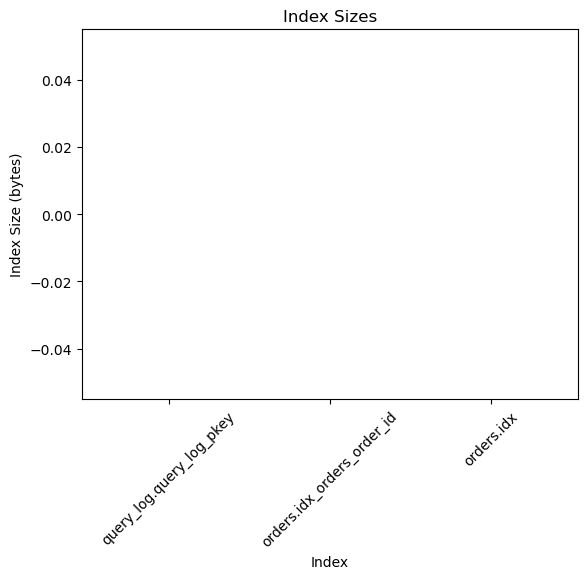

In [10]:
import psycopg2
import matplotlib.pyplot as plt

# Create a connection
conn = psycopg2.connect(database="postgres", user="postgres", password="qwerty", host="localhost", port="5433")


def get_index_sizes():
    index_sizes = []

    with conn.cursor() as cursor:
        cursor.execute("SELECT tablename, indexname "
                       "FROM pg_indexes "
                       "WHERE schemaname = 'public';")
        rows = cursor.fetchall()

        for row in rows:
            table_name, index_name = row
            cursor.execute(f"SELECT pg_total_relation_size('public.{index_name}') - "
                           f"pg_relation_size('public.{index_name}')")
            index_size_bytes = cursor.fetchone()[0]
            index_sizes.append((table_name, index_name, index_size_bytes))

    return index_sizes


def visualize_index_sizes(index_sizes):
    columns = [f"{table_name}.{index_name}" for table_name, index_name, _ in index_sizes]
    sizes = [index_size for _, _, index_size in index_sizes]

    plt.bar(columns, sizes)
    plt.xlabel('Index')
    plt.ylabel('Index Size (bytes)')
    plt.title('Index Sizes')
    plt.xticks(rotation=45)
    plt.show()


# Example usage
index_sizes = get_index_sizes()
visualize_index_sizes(index_sizes)

# Close the connection
conn.close()


In [2]:
def visualize_index_sizes(index_sizes):
    columns, sizes = zip(*index_sizes)

    plt.bar(columns, sizes)
    plt.xlabel('Column')
    plt.ylabel('Index Size (bytes)')
    plt.title('Index Sizes')
    plt.xticks(rotation=45)
    plt.show()


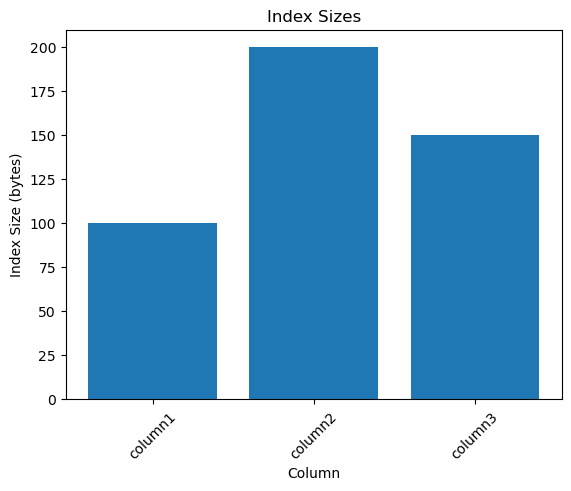

In [3]:
# Example usage
index_sizes = [('column1', 100), ('column2', 200), ('column3', 150)]
visualize_index_sizes(index_sizes)


In [4]:
pip install hyppo-pg


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement hyppo-pg (from versions: none)
ERROR: No matching distribution found for hyppo-pg


In [3]:
import psycopg2
from psycopg2 import sql
from psycopg2.extras import DictCursor
from hyppo.hypopg import HypoPG


def create_hypothetical_index(conn, table_name, index_name, column_names):
    with conn.cursor(cursor_factory=DictCursor) as cursor:
        # Create a HypoPG object
        hypopg = HypoPG(cursor)

        # Create a hypothetical index
        with hypopg.context(index_name):
            create_index_query = sql.SQL("CREATE INDEX {index} ON {table} ({columns})").format(
                index=sql.Identifier(index_name),
                table=sql.Identifier(table_name),
                columns=sql.SQL(', ').join(map(sql.Identifier, column_names))
            )
            cursor.execute(create_index_query)

        # Print the hypothetical index's details
        index_details = hypopg.get_index(index_name)
        print("Hypothetical Index Details:")
        for key, value in index_details.items():
            print(f"{key}: {value}")

        # Rollback the hypothetical index
        hypopg.rollback()

        # Verify that the hypothetical index is rolled back
        index_details = hypopg.get_index(index_name)
        if index_details is None:
            print(f"Hypothetical index {index_name} rolled back successfully.")
        else:
            print(f"Hypothetical index {index_name} rollback failed.")


# Example usage
conn = psycopg2.connect(database="postgres", user="postgres", password="qwerty", host="localhost", port="5433")

# Create a hypothetical index on the "customers" table
table_name = "customers"
index_name = "hypothetical_index_customers"
column_names = ["customer_id"]
create_hypothetical_index(conn, table_name, index_name, column_names)

# Create a hypothetical index on the "orders" table
table_name = "orders"
index_name = "hypothetical_index_orders"
column_names = ["customer_id", "order_date"]
create_hypothetical_index(conn, table_name, index_name, column_names)

conn.close()


ModuleNotFoundError: No module named 'hyppo'